In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
sns.set()

In [192]:
"""
Classes and methods for working with nondeterministic finite automata.
Source: https://github.com/caleb531/automata
"""

import copy
import abc
import math
from random import random, choices
from tqdm.auto import tqdm as tqdm
from collections import defaultdict, Counter

def ddict2dict(d):
    for k, v in d.items():
        if isinstance(v, dict):
            d[k] = ddict2dict(v)
    return dict(d)

def retries_for_sample(kappa: int)->int:
    return math.ceil(
        (2 + math.log(4) + 8 * math.log(kappa)) /
        math.log(1. / (1. - math.exp(-9.)))
    )

class AutomatonException(Exception):
    """The base class for all automaton-related errors."""
    pass


class InvalidStateError(AutomatonException):
    """A state is not a valid state for this automaton."""
    pass


class InvalidSymbolError(AutomatonException):
    """A symbol is not a valid symbol for this automaton."""
    pass


class MissingStateError(AutomatonException):
    """A state is missing from the automaton definition."""
    pass


class RejectionException(AutomatonException):
    """The input was rejected by the automaton."""
    pass


class Automaton(metaclass=abc.ABCMeta):
    """An abstract base class for all automata, including Turing machines."""

    @abc.abstractmethod
    def __init__(self):
        """Initialize a complete automaton."""
        raise NotImplementedError

    @abc.abstractmethod
    def validate(self):
        """Return True if this automaton is internally consistent."""
        raise NotImplementedError

    @abc.abstractmethod
    def read_input_stepwise(self, input_str):
        """Return a generator that yields each step while reading input."""
        raise NotImplementedError

    def read_input(self, input_str, validate_final=True):
        """
        Check if the given string is accepted by this automaton.

        Return the automaton's final configuration. If validate_final is true,
        this will return the final configuration only if this string is valid,
        raising RejectionException otherwise.
        """
        validation_generator = self.read_input_stepwise(input_str, validate_final=validate_final)
        for config in validation_generator:
            pass
        return config
    
    
    def accepts_input(self, input_str):
        """Return True if this automaton accepts the given input."""
        try:
            self.read_input(input_str)
            return True
        except RejectionException:
            return False

    def _validate_initial_state(self):
        """Raise an error if the initial state is invalid."""
        if self.initial_state not in self.states:
            raise InvalidStateError(
                '{} is not a valid initial state'.format(self.initial_state))

    def _validate_initial_state_transitions(self):
        """Raise an error if the initial state has no transitions defined."""
        if self.initial_state not in self.transitions:
            raise MissingStateError(
                'initial state {} has no transitions defined'.format(
                    self.initial_state))

    def _validate_final_states(self):
        """Raise an error if any final states are invalid."""
        invalid_states = self.final_states - self.states
        if invalid_states:
            raise InvalidStateError(
                'final states are not valid ({})'.format(
                    ', '.join(str(state) for state in invalid_states)))

    def copy(self):
        """Create a deep copy of the automaton."""
        return self.__class__(**vars(self))

    def __eq__(self, other):
        """Check if two automata are equal."""
        return vars(self) == vars(other)


class FA(Automaton, metaclass=abc.ABCMeta):
    """An abstract base class for finite automata."""
    pass


class NFA(FA):
    """A nondeterministic finite automaton."""
    def __init__(self, *, states, input_symbols, transitions,
                 initial_state, final_states,
                 states_by_layer=None, reverse_transitions=None):
        """Initialize a complete NFA."""
        self.states = states.copy()
        self.input_symbols = input_symbols.copy()
        self.transitions = copy.deepcopy(transitions)
        self.initial_state = initial_state
        self.final_states = final_states.copy()
        self.validate()

        # --- Counting utilities ---
        self.states_by_layer = states_by_layer
        self.sketch = defaultdict(dict)
        self.n_for_sets = {}
        self.n_for_states = {}
        self.s_for_states = defaultdict(Counter)
        self.reverse_transitions = reverse_transitions
        self.sorted_symbols = sorted(self.input_symbols)
        

    def _validate_transition_invalid_symbols(self, start_state, paths):
        """Raise an error if transition symbols are invalid."""
        for input_symbol in paths.keys():
            if input_symbol not in self.input_symbols and input_symbol != '':
                raise InvalidSymbolError(
                    'state {} has invalid transition symbol {}'.format(
                        start_state, input_symbol))

    def _validate_transition_end_states(self, start_state, paths):
        """Raise an error if transition end states are invalid."""
        for end_states in paths.values():
            for end_state in end_states:
                if end_state not in self.states:
                    raise InvalidStateError(
                        'end state {} for transition on {} is '
                        'not valid'.format(end_state, start_state))

    def validate(self):
        """Return True if this NFA is internally consistent."""
        for start_state, paths in self.transitions.items():
            self._validate_transition_invalid_symbols(start_state, paths)
            self._validate_transition_end_states(start_state, paths)
        self._validate_initial_state()
        self._validate_initial_state_transitions()
        self._validate_final_states()
        return True

    def _get_epsilon_closure(self, start_state):
        """
        Return the epsilon closure for the given state.

        The epsilon closure of a state q is the set containing q, along with
        every state that can be reached from q by following only epsilon
        transitions.
        """
        stack = []
        encountered_states = set()
        stack.append(start_state)

        while stack:
            state = stack.pop()
            if state not in encountered_states:
                encountered_states.add(state)
                if '' in self.transitions[state]:
                    stack.extend(self.transitions[state][''])

        return encountered_states

    def _get_next_current_states(self, current_states, input_symbol):
        """Return the next set of current states given the current set."""
        next_current_states = set()

        for current_state in current_states:
            symbol_end_states = self.transitions[current_state].get(
                input_symbol)
            if symbol_end_states:
                for end_state in symbol_end_states:
                    next_current_states.update(
                        self._get_epsilon_closure(end_state))

        return next_current_states

    def _check_for_input_rejection(self, current_states):
        """Raise an error if the given config indicates rejected input."""
        if not (current_states & self.final_states):
            raise RejectionException(
                'the NFA stopped on all non-final states ({})'.format(
                    ', '.join(str(state) for state in current_states)))

    def read_input_stepwise(self, input_str, validate_final=True):
        """
        Check if the given string is accepted by this NFA.

        Yield the current configuration of the NFA at each step.
        """
        current_states = self._get_epsilon_closure(self.initial_state)

        yield current_states
        for input_symbol in input_str:
            current_states = self._get_next_current_states(
                current_states, input_symbol)
            yield current_states
        
        if validate_final:
            self._check_for_input_rejection(current_states)
            
    def reachable(self, input_str: str, state)->bool:
        """
        Returns true if the NFA reaches the state after reading input_str
        """
        return bool(self.read_input(input_str, validate_final=False) & set([state]))
    

    def unroll(self, n: int):
        """
        Builds A_unroll with n levels
        to estimate |L(F^n)|
        """
        # for each state q ∈ Q, include copies q_0 , q_1 , ..., q n in A unroll
        new_states = {(q,i) for q in self.states for i in range(1, n+1)}
        new_states_by_layer = {i: {(q,i) for q in self.states} for i in range(1, n+1)}
        new_states.update({(q,0) for q in [self.initial_state]})
        new_states_by_layer.update({0: (q,0) for q in [self.initial_state]})
        # for each transition (p, a, q) ∈ ∆ and i ∈ {0, 1, . . . , n − 1}, include
        # transition (p_i, a, q_i+1) in A unroll
        new_transitions = defaultdict(lambda: defaultdict(set))
        rev_transitions = defaultdict(lambda: defaultdict(set))
        for p, trans in self.transitions.items():
            for a, qs in trans.items():
                for q in qs:
                    for i in range(n):
                        # state -> symbol -> set of states
                        new_transitions[p,i][a].add((q,i+1))
                        rev_transitions[q,i+1][a].add((p,i))
        
        new_transitions = ddict2dict(new_transitions)
        rev_transitions = ddict2dict(rev_transitions)
        new_initial_state = (self.initial_state, 0)
        new_final_states = {(q,n) for q in self.final_states}
        
        return NFA(states=new_states,
                   input_symbols=self.input_symbols,
                   transitions=new_transitions,
                   initial_state=new_initial_state,
                   final_states=new_final_states,
                   states_by_layer=new_states_by_layer,
                   reverse_transitions=rev_transitions)
    
    def compute_n_for_single_state(self, state):
        """
        Compute N(pᵅ) = Σ N(R_b) for R_b being the set of 
        incoming states which connect to pᵅ after reading symbol b.
        
        In simple terms, it receives a states and estimates
        the number of different strings leading to it.
        """
        
        if state in self.n_for_states:
            return self.n_for_states[state]
        
        # will store all the states on layer i-1
        # which lead to q after reading b={0,1}
        # {'0': {...leading_states}, '1': {...leading_states}}
        r_b = {}
        # will store all the N(Pᵅ) calculated with `compute_n_for_states_set`
        n_r_b = {}
        for b in self.sorted_symbols:
            if b in self.reverse_transitions[state]:
                leading_states = self.reverse_transitions[state][b]
                r_b[b] = leading_states
                print(f"{state=}", f"{leading_states=}")
                n_r_b[b] = self.compute_n_for_states_set(frozenset(leading_states))
        n_q_alpha = sum(n_r_b.values())
        self.n_for_states[state] = n_q_alpha
        return n_q_alpha
    
    
    def compute_n_for_states_set(self, states: frozenset):
        """
        Compute N(Pᵅ) = Σ N(pᵅ)· |S(pᵅ)-Union(L(qᵅ) for q ≺ p)| / |S(pᵅ)|
        
        In simple terms, it receives a set of states and estimates
        the number of different strings leading to all of them.
        """
        if not states:
            return 0
        
        if states in self.n_for_sets:
            return self.n_for_sets[states]
        
        total = 0
        states_list = sorted(states) # linear order ≺
        for i in range(len(states_list)):
            # states[i] = (q, i), where q is the original state name in A
            anchor_state = states_list[i] 
            state_name, level = anchor_state
            intersection_count = 0
            s_size = 0
            # Now estimate the intersection rate for anchor_state
            for previous_state in states_list[:i]:
                for string, count in self.s_for_states[previous_state].items():
                    s_size += count
                    if not self.reachable(input_str=string, state=previous_state):
                        intersection_count += count
            intersection_rate = intersection_count / s_size if s_size > 0 else 0
            print(anchor_state, self.n_for_states, intersection_rate)
            total += self.compute_n_for_single_state(anchor_state) * intersection_rate
        # cache the result
        self.n_for_sets[states] = total
        return total
        
    
    def sample(self, beta: int, states: frozenset, curr_string: str, phi: float):
        if beta == 0:
            if random() <= phi:
                return curr_string
            return "fail"
        # will store all the states on layer i-1
        # which lead to r after reading b={0,1}
        # {'0': {...leading_states}, '1': {...leading_states}}
        p_beta_b = {}
        # will store all the N(Pᵅ) calculated with `compute_n_for_states_set`
        n_p_beta_b = {}
        
        for b in self.sorted_symbols:
            all_leading_states = set()
            for r in states:
                all_leading_states.update(self.reverse_transitions.get(r, {}).get(b, set()))
            fzset = frozenset(all_leading_states)
            #print(f"{fzset=}")
            p_beta_b[b] = fzset
            n_p_beta_b[b] = self.compute_n_for_states_set(fzset)
            
        sum_n_p_beta = sum(n_p_beta_b.values())
        if sum_n_p_beta == 0:
            #print("Sum = 0")
            return None
        chosen_symbol = choices(self.sorted_symbols, 
                                weights=[n_p_beta_b[b] / sum_n_p_beta for b in self.sorted_symbols],
                                k=1)[0]
        curr_string = chosen_symbol + curr_string # w_beta-1 = b · w_beta
        chosen_states = p_beta_b[chosen_symbol] # p_beta-1 
        new_probability = phi / (n_p_beta_b[chosen_symbol] / sum_n_p_beta) # phi / p_b
        return self.sample(beta=beta-1, states=chosen_states, curr_string=curr_string, phi=new_probability)
    
    
    def count_accepted(self, n:int, eps: float):
        """
        Returns a (1 ± ε)-approximation of |L_n(A_unroll)|
        """
        kappa = math.ceil(n * len(self.states) / eps)
        # c(κ)
        retries_sample = retries_for_sample(kappa)
        sample_size = 2 * kappa # 2 * kappa ** 7
        # For each state q ∈ I, set N(q_0) = |L(q_0)| = 1 
        # and S(q_0) = L(q_0) = {λ}
        for q in self.states_by_layer[0]:
            self.s_for_states[q] = {'': sample_size}
            self.n_for_states[q] = 1
            
        # For each i = 1, . . . , n and state q ∈ Q:
        #   (a) Compute N(q i ) given sketch[i − 1]
        #   (b) Sample polynomially many uniform elements from L(q_i) using
        #       N(q_i) and sketch[i − 1], and let S(q_i) be the multiset of
        #       uniform samples obtained
        for i in range(1, n+1):
            for q in self.states_by_layer[i]:
                n_q_alpha = self.compute_n_for_single_state(q)
                if n_q_alpha == 0:
                    continue
                this_q_samples = Counter()
                for _ in tqdm(range(sample_size)):
                    for retry in range(retries_sample):
                        potential_sample = self.sample(beta=n, 
                                                       states=frozenset([q]),
                                                       curr_string='',
                                                       phi=math.exp(-5)/n_q_alpha)
                        if potential_sample == "fail":
                            print("fail")
                            return 0
                        elif potential_sample is None:
                            continue
                        this_q_samples.update([potential_sample])
                        break
                    
                # print(this_q_samples)
                self.s_for_states[q] = this_q_samples
        return self.compute_n_for_states_set(frozenset(self.final_states))
                        
                
    def bruteforce_save_all(self, n: int):
        if n == 0:
            return [''] if self.accepts_input('') else []
        accepted_strings = []
        for i in range(2**n):
            string_i = bin(i)[2:].zfill(n)
            if self.accepts_input(string_i):
                accepted_strings.append(string_i)
        return accepted_strings

    def bruteforce_count_only(self, n: int):
        if n == 0:
            return 1 if self.accepts_input('') else 0
        accepted_count = 0
        for i in tqdm(range(2**n)):
            string_i = bin(i)[2:].zfill(n)
            if self.accepts_input(string_i):
                accepted_count += 1
        return accepted_count

In [3]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}, '1': {'q3'}},
        'q1': {'0': {'q2'}},
        'q2': {'0': {'q2'}, '1': {'q2'}},
        'q3': {'0': {'q4'}},
        'q4': {'0': {'q5'}},
        'q5': {'0': {'q6'}},
        'q6': {'0': {'q6'}, '1': {'q6'}},
    },
    initial_state='q0',
    final_states={'q2', 'q6'}
)

In [25]:
%%timeit
nfa.bruteforce_count_only(17)

1.46 s ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
nfa.reachable('00101', 'q2')

In [207]:
def count_nfa(nfa: NFA, n: int, eps: float):
    nfa_unroll = nfa.unroll(n)
    return nfa_unroll.count_accepted(n=n, eps=eps)

In [256]:
count_nfa(nfa, 4, 0.99)

state=('q0', 1) leading_states={('q1', 0), ('q2', 0)}
('q1', 0) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1} 0
('q2', 0) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1} 1.0


  0%|          | 0/122 [00:00<?, ?it/s]

state=('q1', 1) leading_states={('q0', 0), ('q1', 0)}
('q0', 0) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, ('q0', 1): 1.0} 0
('q1', 0) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, ('q0', 1): 1.0} 0.0
state=('q2', 1) leading_states={('q1', 0)}
('q1', 0) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, ('q0', 1): 1.0, ('q1', 1): 0.0} 0
state=('q2', 2) leading_states={('q1', 1)}
('q1', 1) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, ('q0', 1): 1.0, ('q1', 1): 0.0, ('q2', 1): 0} 0
state=('q0', 2) leading_states={('q1', 1), ('q2', 1)}
('q1', 1) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, ('q0', 1): 1.0, ('q1', 1): 0.0, ('q2', 1): 0, ('q2', 2): 0.0} 0
('q2', 1) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, ('q0', 1): 1.0, ('q1', 1): 0.0, ('q2', 1): 0, ('q2', 2): 0.0} 0
state=('q1', 2) leading_states={('q0', 1), ('q1', 1)}
('q0', 1) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, ('q0', 1): 1.0, ('q1', 1): 0.0, ('q2', 1): 0, ('q2', 2): 0.0, ('q0', 2): 0.0} 0
('q1', 1) {('q0', 0): 1, ('q1', 0): 1, ('q2', 0): 1, 

0.0

In [91]:
189863754266 / 1e9

189.863754266

In [238]:
nfa.accepts_input('')

False

In [33]:
bin(1/3)

TypeError: 'float' object cannot be interpreted as an integer

In [48]:
x = np.array([1.,2.,3.])


array([2., 3., 4.])

# Experimentos estadísticos

In [194]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {'0': {'q1'}, '1': {'q0', 'q2'}},
        'q2': {'1': {'q0'}}
    },
    initial_state='q0',
    final_states={'q1'}
)

In [129]:
%%time
data = [(i,nfa.bruteforce_count_only(i)/2**i) for i in range(1, 23)]

CPU times: user 1min 50s, sys: 0 ns, total: 1min 50s
Wall time: 1min 50s


In [130]:
df = pd.DataFrame(data, columns=["i", "frac"])

<AxesSubplot:xlabel='i'>

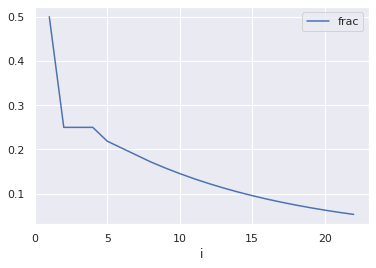

In [131]:
df.plot(x="i", y="frac")

<AxesSubplot:xlabel='i'>

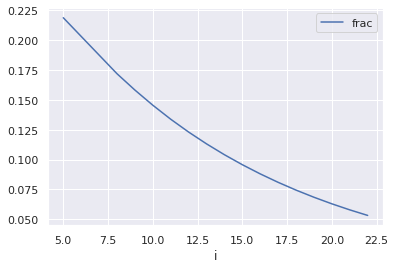

In [132]:
df[df.i >= 5].plot(x="i", y="frac")

In [167]:
def fit_function(x, a, b, c):
    return a*b**(c*x)

In [219]:
predictable_data = df[df.i.between(8,14)]

In [220]:
x_data = predictable_data.i.values
y_data = predictable_data.frac.values
popt, pcov = scipy.optimize.curve_fit(fit_function, x_data, y_data, maxfev=1000)

/home/victor/Documentos/Ramos/iPre/count-nfa/venv/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


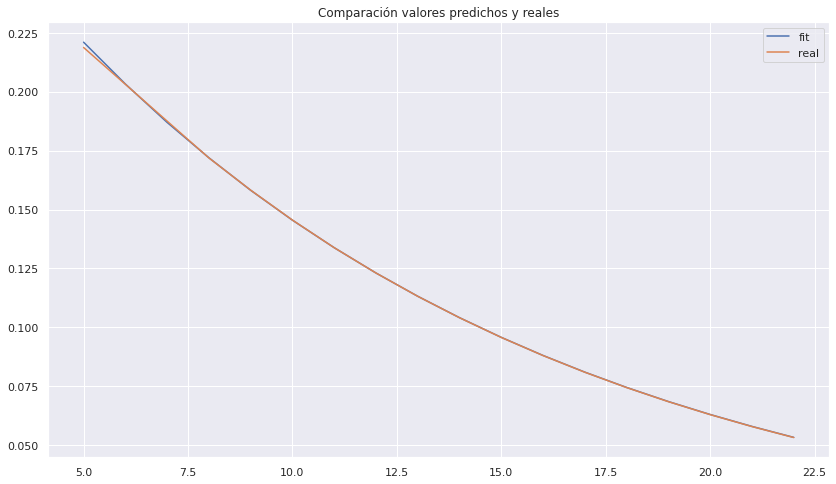

In [221]:
all_data = df[df.i >= 5]
all_x_data = all_data.i.values
all_y_data = all_data.frac.values

fig = plt.plot(all_x_data, fit_function(all_x_data, *popt), label="fit")
plt.plot(all_x_data, all_y_data, label="real")
plt.legend();
plt.title("Comparación valores predichos y reales")
plt.gcf().set_size_inches((14,8))

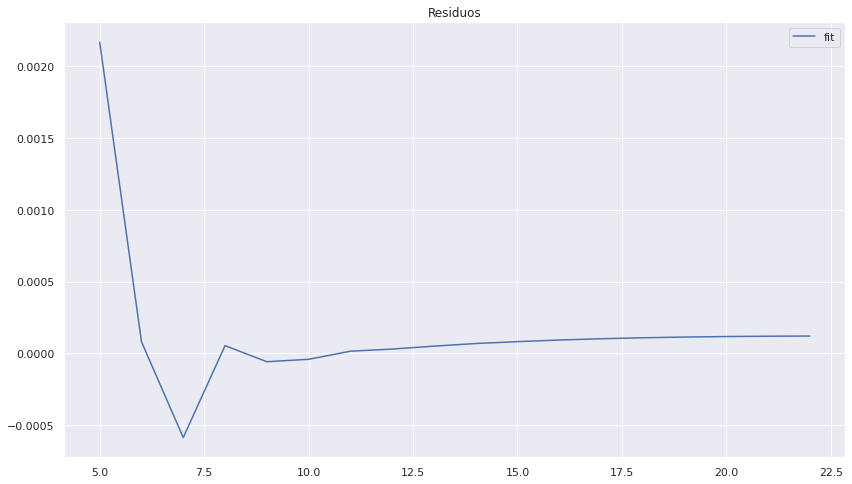

In [216]:
plt.plot(all_x_data, fit_function(all_x_data, *popt) - all_y_data, label="fit")
plt.legend();
plt.title("Residuos")
plt.gcf().set_size_inches((14,8))

In [222]:
k = 24
pred_for_k = fit_function(k, *popt) * 2**k
pred_for_k

756558.0107414507

In [199]:
%%time
ground_truth_k = nfa.bruteforce_count_only(k)
ground_truth_k

  0%|          | 0/16777216 [00:00<?, ?it/s]

CPU times: user 4min 29s, sys: 1.48 s, total: 4min 30s
Wall time: 4min 30s


755476

In [182]:
popt

array([0.33575909, 0.93957975, 1.34223468])

In [183]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

0.0013142664389303824

In [223]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

0.00143222384490137

- https://arxiv.org/pdf/1802.04708.pdf -> si A es acíclico, el lenguaje es finito. De hecho, $L(A) \subseteq (\Sigma \cup \{\epsilon\})^{|Q|}$
- En general, para $n < |Q|$ el comportamiento se puede hardcodear, por lo que fuerza bruta o `sketch` son necesarios
- http://www.stringology.org/cgi-bin/getfile.cgi?t=pdf&c=-&y=2013&n=03 -> hay un algoritmo $O(|Q|^2)$ para determinar si la densidad del lenguaje es exponencial o polinomial
    - Hipótesis 1: si el lenguaje tiene densidad exponencial, el gráfico $|L_n(A)|/2^n$ se verá como una constante tras al menos $n=|Q|$. Estimar es trivial para $n \gg |Q|$, basta retornar esa proporción multiplicada por $2^n$
    - Hipótesis 2: si el lenguaje tiene densidad polinomial, el gráfico $|L_n(A)|/2^n$ se verá como una exponencial
    decayendo. Se puede fittear una función y aproximar para $n \gg |Q|$